In [1]:
import time
from IPython.display import clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from utils.data_preparation import WalkFwGenerator
from models.encoder import EncoderRNN
from models.decoder import DecoderRNN, AttnDecoderRNN

from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [283]:
df = pd.read_csv('monthly-lake-erie-levels-1921-19.csv')
lake = df[df.columns[1]].values
lake = lake[:-1]

In [284]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')
milk = df[df.columns[1]].values
milk = milk[:-1]

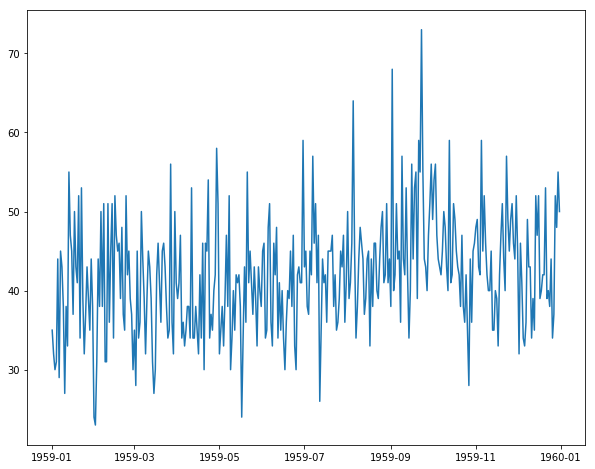

In [236]:
df = pd.read_csv('daily-total-female-births-in-cal.csv')
df = df[df.Date != 'Daily total female births in California']
df.loc[:,'Date'] = df.Date.map(lambda x: pd.to_datetime(x))
def date_to_index(start_date, end_date):
    return df.index[df.Date == start_date][0], df.index[df.Date == end_date][0]
df = df.rename(columns={'Daily total female births in California, 1959': 'births'})
df = df.sort_values('Date')
plt.plot(df.Date, df.births)

# Training

In [259]:
def train(enc, dec, epochs, wfg, window, n_targets):
    history = {}
    enc_optimizer = optim.ASGD(enc.parameters(),)
    dec_optimizer = optim.ASGD(dec.parameters(),)
    criterion = nn.SmoothL1Loss()
    losses = []
    for epoch in range(epochs+1):
        start_time = time.time()
        history[epoch] = {}
        train_outputs, train_losses = forward(enc, dec, criterion, enc_optimizer, dec_optimizer, wfg, history[epoch])
        print('Epoch: {}, AVG. MSELoss: {}'.format(epoch, np.sum(train_losses)/len(list(wfg.reset()))))
        print('--- %s seconds ---' % (time.time() - start_time))
        print('')
        losses.append(np.sum(train_losses)/len(list(wfg.reset())))
        outputs_0 = np.array(list(map(lambda x: x.detach().numpy()[0][n_targets-1], train_outputs))).flatten()
        outputs_n = np.array(list(map(lambda x: x.detach().numpy()[0][0], train_outputs))).flatten()
        if (epoch % 5) == 0:
            history[epoch]['outputs'] = outputs_0
            history[epoch]['losses'] = train_losses
        plt.plot(values[window:])
        plt.plot(outputs_0)
        plt.plot(outputs_n)
        plt.show()
        if (epoch > 2):
            plt.plot(losses[2:])
            plt.show()
        clear_output(wait=True)
    return history

In [260]:
def forward(enc, dec, criterion, enc_optimizer, dec_optimizer, wfg, history, _eval=False):
    if not _eval: enc.train(); dec.train()
    else: enc.eval(); dec.eval()
    
    outputs = []
    losses = []
    for encoder_input_data, decoder_input_data, decoder_target_data in wfg.reset():
        loss = 0
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        encoder_hidden = enc.initHidden()
        encoder_outputs = torch.zeros(decoder_input_data.shape[0], enc.hidden_size, device=device)
        for ei in range(decoder_input_data.shape[0]):
            encoder_output, encoder_hidden = enc(decoder_input_data[ei].view(1, 1, -1), encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        # output, hidden = enc(encoder_input_data, enc.initHidden())
        output, hidden, attn_weights = dec(decoder_input_data, encoder_hidden, encoder_outputs)
        outputs.append(output)
        loss = criterion(output, decoder_target_data)
        losses.append(loss.item())
        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()
    return outputs, losses

In [285]:
# ------ HYPERPARAMS -------
# epochs
N_EPOCHS = 100
# how many samples to use to predict
window = 40
# how many targets to predict
targets = 5

values = milk
# values = lake
# values = df.births.values

values = (values - np.mean(values)) / np.std(values)
# Generator
wfg = WalkFwGenerator(X=values, window=window, n_targets=targets)

# Models (encoder + decoder with attention)
enc = EncoderRNN(1, 128, device=device)
dec = AttnDecoderRNN(128, targets, device=device)

Epoch: 100, AVG. MSELoss: 0.24218776910129236
--- 1.3118460178375244 seconds ---



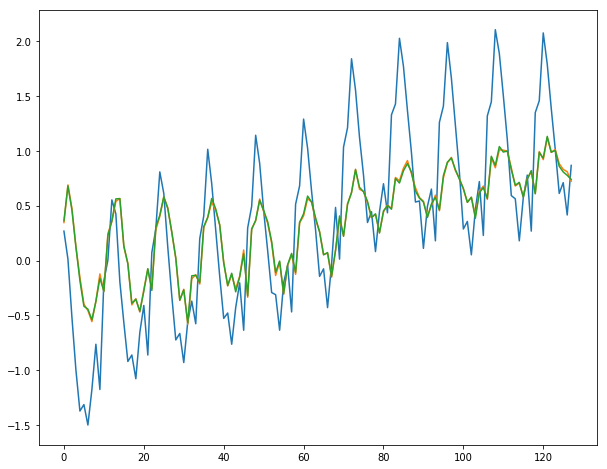

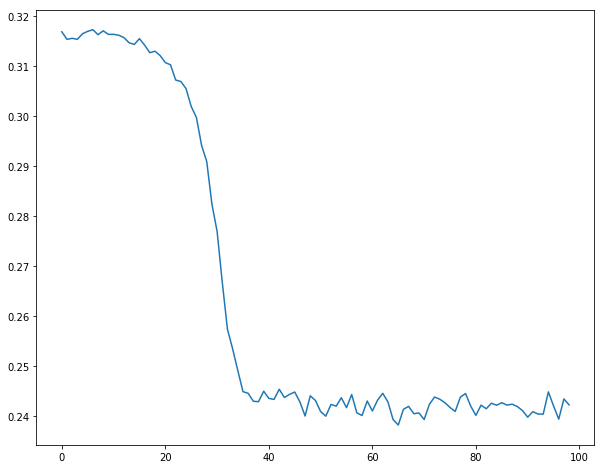

In [286]:
# Training with Walk-Fw Validation
train_history = train(enc, dec, epochs=N_EPOCHS, wfg=wfg, window=window, n_targets=targets)